> 🩺 Este notebook forma parte del proyecto **NutriSynthCare**, un entorno de simulación sobre salud pública y recomendaciones nutricionales personalizadas.  
>
> 👥 Desarrollado por:  
> - Daniel Cruz – [dCruzCoding](https://github.com/dCruzCoding)  
> - Aníbal García – [Aniballll](https://github.com/Aniballll)  
>
> 📁 Repositorio completo: [NutriSynthCare](https://github.com/tu-repo-aqui)  
>
> 📜 Licencia: Este proyecto está disponible bajo la licencia MIT. Consulta el archivo `LICENSE` para más información.  
>
> 🙏 Agradecimientos especiales a todas las fuentes de datos y literatura científica que han hecho posible la creación de las bases sintéticas utilizadas en este proyecto.  
>
> 🤝 ¿Te interesa colaborar? ¡Estás invitado!  
> Puedes contribuir mejorando los notebooks, proponiendo nuevas ideas o corrigiendo errores:  
> - Haz un fork del repo  
> - Crea una rama (`git checkout -b mejora/nueva-idea`)  
> - Abre un Pull Request explicando tu propuesta

# =========================================================================
# ⚙️ PIPELINE DE LA GENERACIÓN DE LA BASE DE DATOS
# RIESGO CARDIOVASCULAR ❤️ EN PERSONAS CON DIABETES 🩸
# =========================================================================

```text
+---------------------------------+      +-----------------------------------------+
|    DB Sintética 1: Diabetes     |      |  DB Sintética 2: Riesgo Cardiovascular  |
+---------------------------------+      +-----------------------------------------+
             |                                              |
             '--------------------. .-----------------------'
                                  |
                                  v
                  +--------------------------------+
                  |    1. UNIÓN DE BASES DE DATOS  |
                  |     (Outer Join por columnas   |
                  |           comunes)             |
                  +--------------------------------+
                                  |
                                  v
        +---------------------------------------------------------+
        |         Dataset Combinado con Valores Faltantes (NaN)   |
        +---------------------------------------------------------+
                                  |
                                  v
+----------------------------------------------------------------------------------+
|               2. PROCESO DE IMPUTACIÓN SECUENCIAL Y CONDICIONAL                  |
|                                                                                  |
|   +--------------------------------------------------------------------------+   |
|   |   FASE 1: IMPUTACIÓN DE VARIABLES NUMÉRICAS                              |   |
|   |   (HbA1c, Insulina, HDL, LDL, etc.)                                      |   |
|   |   +------------------------------------------------------------------+   |
|   |   | - Análisis de correlación para cada variable.                    |   |
|   |   | - SI hay relación fuerte -> Imputar con REGRESIÓN LINEAL MÚLTIPLE. |   |
|   |   | - SI NO hay relación   -> EXCLUIR VARIABLE para evitar ruido.     |   |
|   |   +------------------------------------------------------------------+   |
|   +--------------------------------------------------------------------------+
|                                     |
|                                     v
|   +--------------------------------------------------------------------------+
|   |   FASE 2: IMPUTACIÓN DE VARIABLES CATEGÓRICAS (En tres etapas)           |
|   |                                                                          |
|   |   --> ETAPA 2.1: Variables de Contexto (Actividad, Estrés, etc.)         |
|   |   |   +--------------------------------------------------------------+   |
|   |   |   | Se imputan primero con un clasificador (ej. XGBoost) si      |   |
|   |   |   | muestran asociación suficiente.                              |   |
|   |   |   +--------------------------------------------------------------+   |
|   |                                     |                                    |
|   |                                     v                                    |
|   |                                                                          |
|   |   --> ETAPA 2.2: Variable Clave -> Tipo_Diabetes                         |
|   |   |   +--------------------------------------------------------------+   |
|   |   |   | 1. IMPUTACIÓN INTELIGENTE (??)                               |   |
|   |   |   | 2. ANÁLISIS Y SELECCIÓN de las variables predictoras más     |   |
|   |   |   |    relevantes.                                               |   |
|   |   |   | 3. IMPUTACIÓN FINAL: Se entrena un RandomForestClassifier    |   |
|   |   |   |    con las variables seleccionadas para predecir los NaN.    |   |
|   |   |   +--------------------------------------------------------------+   |
|   |                                     |                                    |
|   |                                     v                                    |
|   |                                                                          |
|   |   --> ETAPA 2.3: Variable Clave -> Riesgo_Cardiovascular                 |
|   |       +--------------------------------------------------------------+   |
|   |       | Se imputa al final, usando el dataset ya enriquecido con     |   |
|   |       | las imputaciones de 'Tipo_Diabetes' y las demás variables.   |   |
|   |       +--------------------------------------------------------------+   |
|   |                                                                          |
+----------------------------------------------------------------------------------+
                                     |
                                     v
                  +--------------------------------------+
                  |    DATASET FINAL IMPUTADO (PARCIAL)  |
                  | (Algunas variables pueden haber sido |
                  | excluidas si no cumplían criterios)  |
                  |   (Listo para análisis y modelado)   |
                  +--------------------------------------+

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Reproducibilidad
np.random.seed(42)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Cargamos los csv y lo convertimos en dataframe
df = pd.read_csv("db_cardiabetes.csv")

display(df)

,Año_Registro,Edad,IMC,Diabetes,Colesterol_Total,Trigliceridos,PAS,PAD,Cohorte,HbA1c,Insulina,LDL,HDL,Nivel_Estres,Actividad_Fisica,Riesgo_Cardiovascular,Sexo,Tipo_Diabetes
0,2016,-0.804483,-0.362909,0,203.053597,-0.525838,-1.113528,-1.128432,cardio,5.483777,10.602855,111.284292,71.456754,Alto,Moderado,Bajo,Hombre,NaN
1,2013,1.050480,-2.271737,0,214.198250,0.114886,-0.658882,-1.507895,cardio,5.212008,56.952216,124.064267,48.292897,Moderado,Sedentario,Bajo,Mujer,NaN
2,2017,1.335859,0.097390,0,178.338545,-0.998805,-0.187398,-1.371288,cardio,6.750564,92.875636,123.757918,55.659980,Moderado,Moderado,Bajo,Mujer,NaN
3,2014,0.194343,1.868184,0,208.059981,-0.049786,1.336506,-0.308793,cardio,4.659614,188.637574,110.158158,54.487884,Moderado,Sedentario,Bajo,Mujer,NaN
4,2016,0.337033,-0.081596,1,260.781259,0.017413,0.418796,-0.490935,cardio,7.436320,66.564019,120.410972,52.990636,Moderado,Sedentario,Moderado,Mujer,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,2017,-0.634414,-0.096697,1,210.750000,-0.361928,-0.692497,-0.478777,diabetes,5.840000,4.450000,96.230000,53.870000,Bajo,Moderado,NaN,Hombre,Tipo 1
15996,2012,-0.809270,0.745440,1,226.150000,0.743030,-0.274150,0.519960,diabetes,7.810000,79.930000,107.710000,43.000000,Alto,Moderado,NaN,Hombre,Tipo 2
15997,2012,-0.109843,-0.426947,1,215.130000,-1.201495,-0.632733,-0.349528,diabetes,7.370000,12.610000,103.980000,50.240000,Bajo,Activo,NaN,Hombre,Tipo 1
15998,2016,1.376441,-1.170009,1,228.540000,0.106274,0.436374,-0.373028,diabetes,8.100000,0.390000,108.890000,54.810000,Alto,Sedentario,NaN,Mujer,Tipo 1


In [3]:
df.columns

Index(['Año_Registro', 'Edad', 'IMC', 'Diabetes', 'Colesterol_Total',
       'Trigliceridos', 'PAS', 'PAD', 'Cohorte', 'HbA1c', 'Insulina', 'LDL',
       'HDL', 'Nivel_Estres', 'Actividad_Fisica', 'Riesgo_Cardiovascular',
       'Sexo', 'Tipo_Diabetes'],
      dtype='object')

In [4]:
print("--- ANÁLISIS DEL PAISAJE DE DATOS FALTANTES PARA 'Tipo_Diabetes' ---")

# 1. ¿Hay casos ilógicos? (Pacientes SIN diabetes pero con 'Tipo_Diabetes' nulo)
casos_ilogicos = df[(df['Diabetes'] == 0) & (df['Tipo_Diabetes'].isnull())]
print(f"\n1. Pacientes con 'Diabetes'=0 pero 'Tipo_Diabetes'=NaN: {len(casos_ilogicos)} filas.")
if len(casos_ilogicos) > 0:
    print("   ✅ ACCIÓN RECOMENDADA: Se puede imputar 'No diabetes' a estas filas con 100% de certeza.")

# 2. ¿Cuál es el perfil del verdadero grupo a imputar?
#    (Pacientes CON diabetes pero con 'Tipo_Diabetes' nulo)
grupo_a_imputar = df[(df['Diabetes'] == 1) & (df['Tipo_Diabetes'].isnull())]
print(f"\n2. Pacientes con 'Diabetes'=1 pero 'Tipo_Diabetes'=NaN: {len(grupo_a_imputar)} filas.")

# 3. ¿Qué sabemos de los predictores clave de este grupo?
if not grupo_a_imputar.empty:
    print("\n   Análisis de los predictores de diagnóstico para este grupo problemático:")
    # Columnas que un médico usaría para diagnosticar el tipo
    predictores_diagnostico = ['HbA1c', 'Insulina', 'Edad', 'IMC']
    
    # Nos aseguramos de que las columnas existen en el df
    predictores_existentes = [p for p in predictores_diagnostico if p in df.columns]
    
    if predictores_existentes:
        print(grupo_a_imputar[predictores_existentes].describe())
    else:
        print("   No se encontraron columnas de diagnóstico primario (HbA1c, Insulina, etc.) para analizar.")
else:
    print("\n   ¡No hay casos problemáticos que necesiten imputación por ML!")

--- ANÁLISIS DEL PAISAJE DE DATOS FALTANTES PARA 'Tipo_Diabetes' ---

1. Pacientes con 'Diabetes'=0 pero 'Tipo_Diabetes'=NaN: 5639 filas.
   ✅ ACCIÓN RECOMENDADA: Se puede imputar 'No diabetes' a estas filas con 100% de certeza.

2. Pacientes con 'Diabetes'=1 pero 'Tipo_Diabetes'=NaN: 2361 filas.

   Análisis de los predictores de diagnóstico para este grupo problemático:
             HbA1c     Insulina         Edad          IMC
count  2361.000000  2361.000000  2361.000000  2361.000000
mean      7.577510   110.702633     0.400551     0.656970
std       1.044388    55.673175     0.905964     0.872743
min       3.938108     0.000000    -3.230205    -2.378797
25%       6.897659    71.420267    -0.233725     0.034722
50%       7.566066   110.975947     0.479722     0.667571
75%       8.331090   149.452211     1.050480     1.260531
max      11.317286   294.321897     2.191996     2.667191



--- ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS) CON BOX PLOTS ---

--- DIAGRAMA DE CAJA: Grupo 1 (Variables clínicas clave) ---


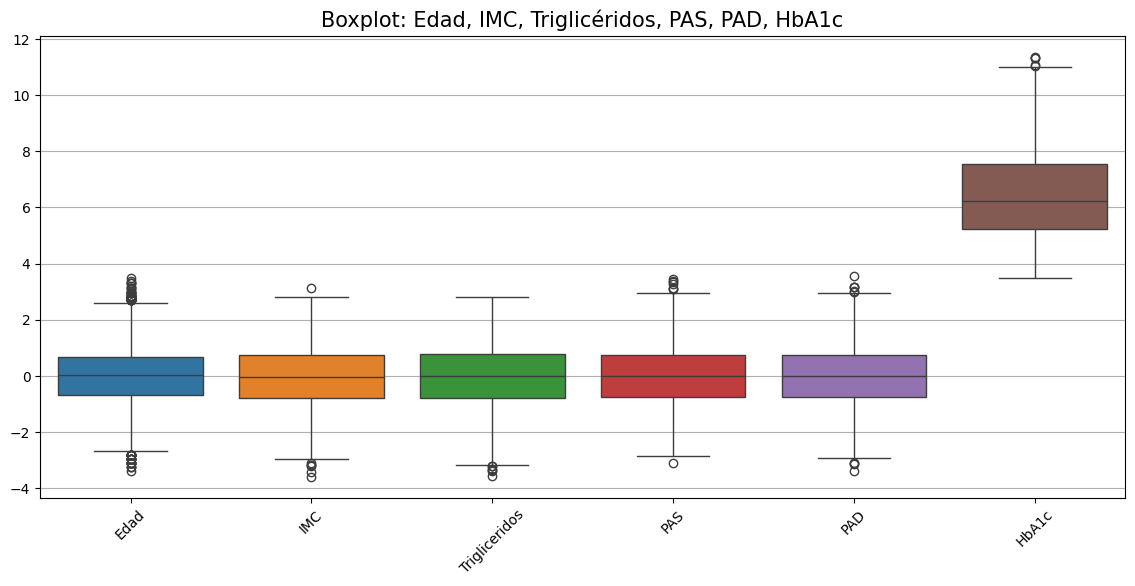


--- DIAGRAMA DE CAJA: Grupo 2 (Resto de variables) ---


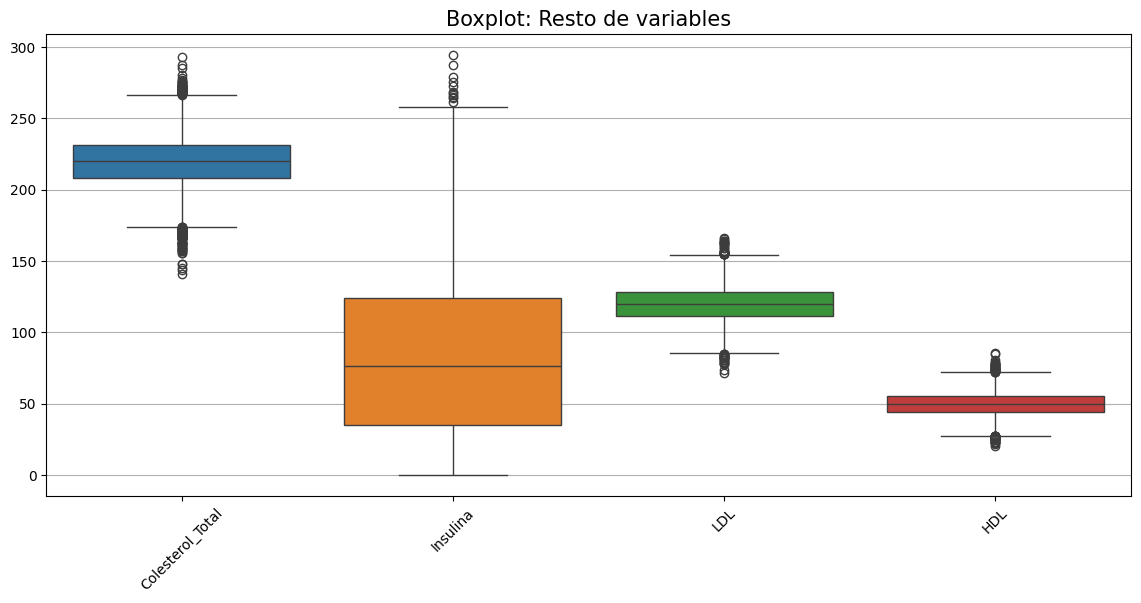

In [5]:
# --- Lista de variables numéricas a revisar ---
vars_predictoras_num = [
    'Edad', 'IMC', 'Colesterol_Total', 'Trigliceridos', 
    'PAS', 'PAD', 'HbA1c', 'Insulina', 'LDL', 'HDL']  

# Asegurarnos de que solo analizamos columnas que existen en el DataFrame
vars_existentes = [var for var in vars_predictoras_num if var in df.columns]

# --- Generación de Box Plots ---
print("\n--- ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS) CON BOX PLOTS ---")

# --- Variables a separar ---
grupo_1 = ['Edad', 'IMC', 'Trigliceridos', 'PAS', 'PAD', 'HbA1c']
grupo_2 = [var for var in vars_existentes if var not in grupo_1]

# --- Boxplot Grupo 1 ---
print("\n--- DIAGRAMA DE CAJA: Grupo 1 (Variables clínicas clave) ---")
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[grupo_1])
plt.title("Boxplot: Edad, IMC, Triglicéridos, PAS, PAD, HbA1c", fontsize=15)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# --- Boxplot Grupo 2 ---
print("\n--- DIAGRAMA DE CAJA: Grupo 2 (Resto de variables) ---")
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[grupo_2])
plt.title("Boxplot: Resto de variables", fontsize=15)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [6]:
# --- Detección de outliers usando el método IQR ---
outliers_info = {}

for col in vars_existentes:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    n_outliers = outliers.count()
    
    outliers_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límite Inferior': lower_bound,
        'Límite Superior': upper_bound,
        'Nº de Outliers': n_outliers,
        'Porcentaje de Outliers': (n_outliers / len(df)) * 100,
        'Valores Ejemplo': outliers.head(5).tolist()
    }

# Mostrar resumen
pd.DataFrame(outliers_info).T.round(2)


,Q1,Q3,IQR,Límite Inferior,Límite Superior,Nº de Outliers,Porcentaje de Outliers,Valores Ejemplo
Edad,-0.661794,0.677013,1.338807,-2.670004,2.685223,71,0.44375,"[-2.9448258935424176, -2.8021363939037696, -2...."
IMC,-0.767177,0.748016,1.515193,-3.039966,3.020806,7,0.04375,"[-3.211514622305488, -3.107878027577578, -3.15..."
Colesterol_Total,208.390551,231.600343,23.209792,173.575863,266.415031,169,1.05625,"[272.4084811569402, 266.7071757864516, 267.677..."
Trigliceridos,-0.797927,0.790535,1.588463,-3.180621,3.173229,6,0.0375,"[-3.3676810623919624, -3.295280936189149, -3.1..."
PAS,-0.752261,0.738732,1.490992,-2.988749,2.97522,8,0.05,"[3.138249513542279, -3.0920777369990766, 3.281..."
PAD,-0.764148,0.731457,1.495605,-3.007556,2.974865,10,0.0625,"[3.000119293647135, -3.086458384615657, 3.1519..."
HbA1c,5.22028,7.54,2.31972,1.7407,11.01958,5,0.03125,"[11.31728640078602, 11.03, 11.31, 11.37, 11.08]"
Insulina,34.800139,124.297175,89.497036,-99.445416,258.542729,11,0.06875,"[266.27498809549047, 261.56205488731234, 275.0..."
LDL,111.26,128.58,17.32,85.28,154.56,56,0.35,"[84.43306473060767, 156.76895782160742, 82.943..."
HDL,44.335423,55.57,11.234577,27.483557,72.421866,75,0.46875,"[77.52520284219392, 75.59611994714749, 27.0117..."


### 🧪 Rangos de Referencia para Variables Médicas (Ajustados)

A continuación, una tabla orientativa con **rangos típicos y umbrales clínicos** para las variables analizadas. Esto puede ayudar a decidir si los *outliers* son razonables o potencialmente erróneos.
**IMPORTANTE:** los rangos han tenido en cuenta el contexto específico de esta base de datos (diabetes y riesgo cardiovascular).

---

#### 📊 Variables en escala original (sin normalizar)

| Variable                                | Rango Plausible Ajustado | Observaciones                                                                  |
| --------------------------------------- | ------------------------ | ------------------------------------------------------------------------------ |
| **Edad**   ⚠️                            | 0 – 120 años             | Valores negativos o >120 probablemente son errores.                            |
| **IMC**   ⚠️                             | 10 – 70                  | Valores >50 son poco comunes, pero pueden darse en obesidad mórbida severa.    |
| **Colesterol\_Total**                   | 100 – 400 mg/dL          | >240 es *alto*, >400 es raro pero posible en desórdenes graves.                |
| **Triglicéridos**    ⚠️                  | 30 – 1200 mg/dL          | >500 es *muy alto*, >1000 se ve en casos extremos (diabéticos no controlados). |
| **PAS** ⚠️ *(Presión arterial sistólica)*  | 70 – 260 mmHg            | Riesgo cardiovascular permite PAS >200. <70 o >260 puede ser error o crítico.  |
| **PAD** ⚠️ *(Presión arterial diastólica)* | 35 – 150 mmHg            | Hasta 140–150 puede verse en hipertensión severa. <35 suele indicar error.     |
| **HbA1c**                               | 3 – 16 %                 | >12% en diabéticos mal controlados. <3% o >16% suelen indicar error.           |
| **Insulina**                            | 0 – 300 µU/mL            | Población con DT2 puede tener valores hasta 250–300 µU/mL.                     |
| **LDL**                                 | 30 – 300 mg/dL           | >250 es poco común y sospechoso, pero posible.                                 |
| **HDL**                                 | 10 – 150 mg/dL           | Muy altos (>100) pueden ocurrir; <10 probablemente erróneo.                    |

---

#### 🔧 Variables ya normalizadas (con `StandardScaler`)

Para las variables que han sido **normalizadas** (Edad, IMC, Triglicéridos, PAS, PAD), los valores extremos se identifican de otra forma:

* **Criterio habitual:** eliminar valores con un `z-score` > 3 o < -3.
* Esto equivale a estar a más de 3 desviaciones estándar de la media (en distribución normal, es <0.3% de los datos).
* Se asume que los valores están estandarizados con media ≈ 0 y desviación ≈ 1.

📌 **Ejemplo:** si Edad normalizada tiene valor -4.5 → está 4.5 sigmas por debajo de la media → *potencial outlier*.

---

### 🔍 Recomendaciones por tipo

* **Variables como Edad o IMC:** si ya están normalizadas, usa z-score. Si no, aplica los rangos clínicos de la tabla.
* **Variables clínicas (HDL, LDL, etc.):** mantén los rangos absolutos si no has aplicado transformación. Si piensas normalizarlas luego, considera limpiar antes.
* **¿Qué hacer con los *outliers*?**

  1. **Eliminar filas con errores claros o imposibles.**
  2. **Revisar visualmente y decidir si conservar valores extremos plausibles.**
  3. **Aplicar transformaciones (log, z-score) o imputar si hay coherencia contextual.**
  4. **Usar banderas binarias (`is_outlier`) como variables auxiliares en tus modelos.**



In [7]:
def detectar_outliers_df_global(df, cols_normalizadas, cols_sin_normalizar, umbral_z=3):
    """
    Aplica detección de outliers sobre un DataFrame ya combinado.
    Usa z-score en columnas normalizadas, y rangos clínicos globales para las otras.
    """

    rangos_referencia = {
        'Edad': (0, 120),
        'IMC': (10, 70),
        'Colesterol_Total': (100, 400),
        'Trigliceridos': (30, 1200),
        'PAS': (70, 260),
        'PAD': (35, 150),
        'HbA1c': (3, 16),
        'Insulina': (0, 300),
        'LDL': (30, 300),
        'HDL': (10, 150)
    }

    outlier_flags = pd.DataFrame(index=df.index)

    # Z-score para normalizadas (ya lo están, no recalculamos)
    for col in cols_normalizadas:
        outlier_flags[col] = df[col].abs() > umbral_z

    # Rangos clínicos para sin normalizar
    for col in cols_sin_normalizar:
        if col in rangos_referencia:
            min_val, max_val = rangos_referencia[col]
            outlier_flags[col] = (df[col] < min_val) | (df[col] > max_val)
        else:
            outlier_flags[col] = False

    any_outlier = outlier_flags.any(axis=1)
    df_clean = df[~any_outlier].copy()

    return df_clean, outlier_flags, any_outlier



In [8]:
cols_norm = ['Edad', 'IMC', 'Trigliceridos', 'PAS', 'PAD']
cols_no_norm = ['Colesterol_Total', 'HbA1c', 'Insulina', 'LDL', 'HDL']

df, flags_outliers, mask_outliers = detectar_outliers_df_global(
    df,
    cols_normalizadas=cols_norm,
    cols_sin_normalizar=cols_no_norm
)

print(f"Número de filas eliminadas por outliers: {mask_outliers.sum()}")

Número de filas eliminadas por outliers: 51


###  Volvemos con la IMPUTACIÓN de Tipo_Diabetes

In [9]:
print(f"\nPacientes con 'Tipo_Diabetes'=NaN: {df['Tipo_Diabetes'].isnull().sum()} filas.")


Pacientes con 'Tipo_Diabetes'=NaN: 7962 filas.


In [10]:

print("--- PLAN DE IMPUTACIÓN PARA 'Tipo_Diabetes' ---")

# --- Paso 1: Imputación por Regla Lógica (Casos No Diabéticos) ---
# Si un paciente no tiene diabetes ('Diabetes' == 0), su tipo es, por definición, 'No diabetes'.
# Esta es una imputación basada en certeza, no en inferencia.
print("\nPaso 1: Imputando 'No diabetes' a pacientes no diabéticos...")
num_nulos_antes_paso1 = df['Tipo_Diabetes'].isnull().sum()
df.loc[df['Diabetes'] == 0, 'Tipo_Diabetes'] = 'No diabetes'
num_imputados_paso1 = num_nulos_antes_paso1 - df['Tipo_Diabetes'].isnull().sum()
print(f"   ✅ Se han imputado {num_imputados_paso1} filas con 100% de certeza.")

--- PLAN DE IMPUTACIÓN PARA 'Tipo_Diabetes' ---

Paso 1: Imputando 'No diabetes' a pacientes no diabéticos...
   ✅ Se han imputado 5613 filas con 100% de certeza.


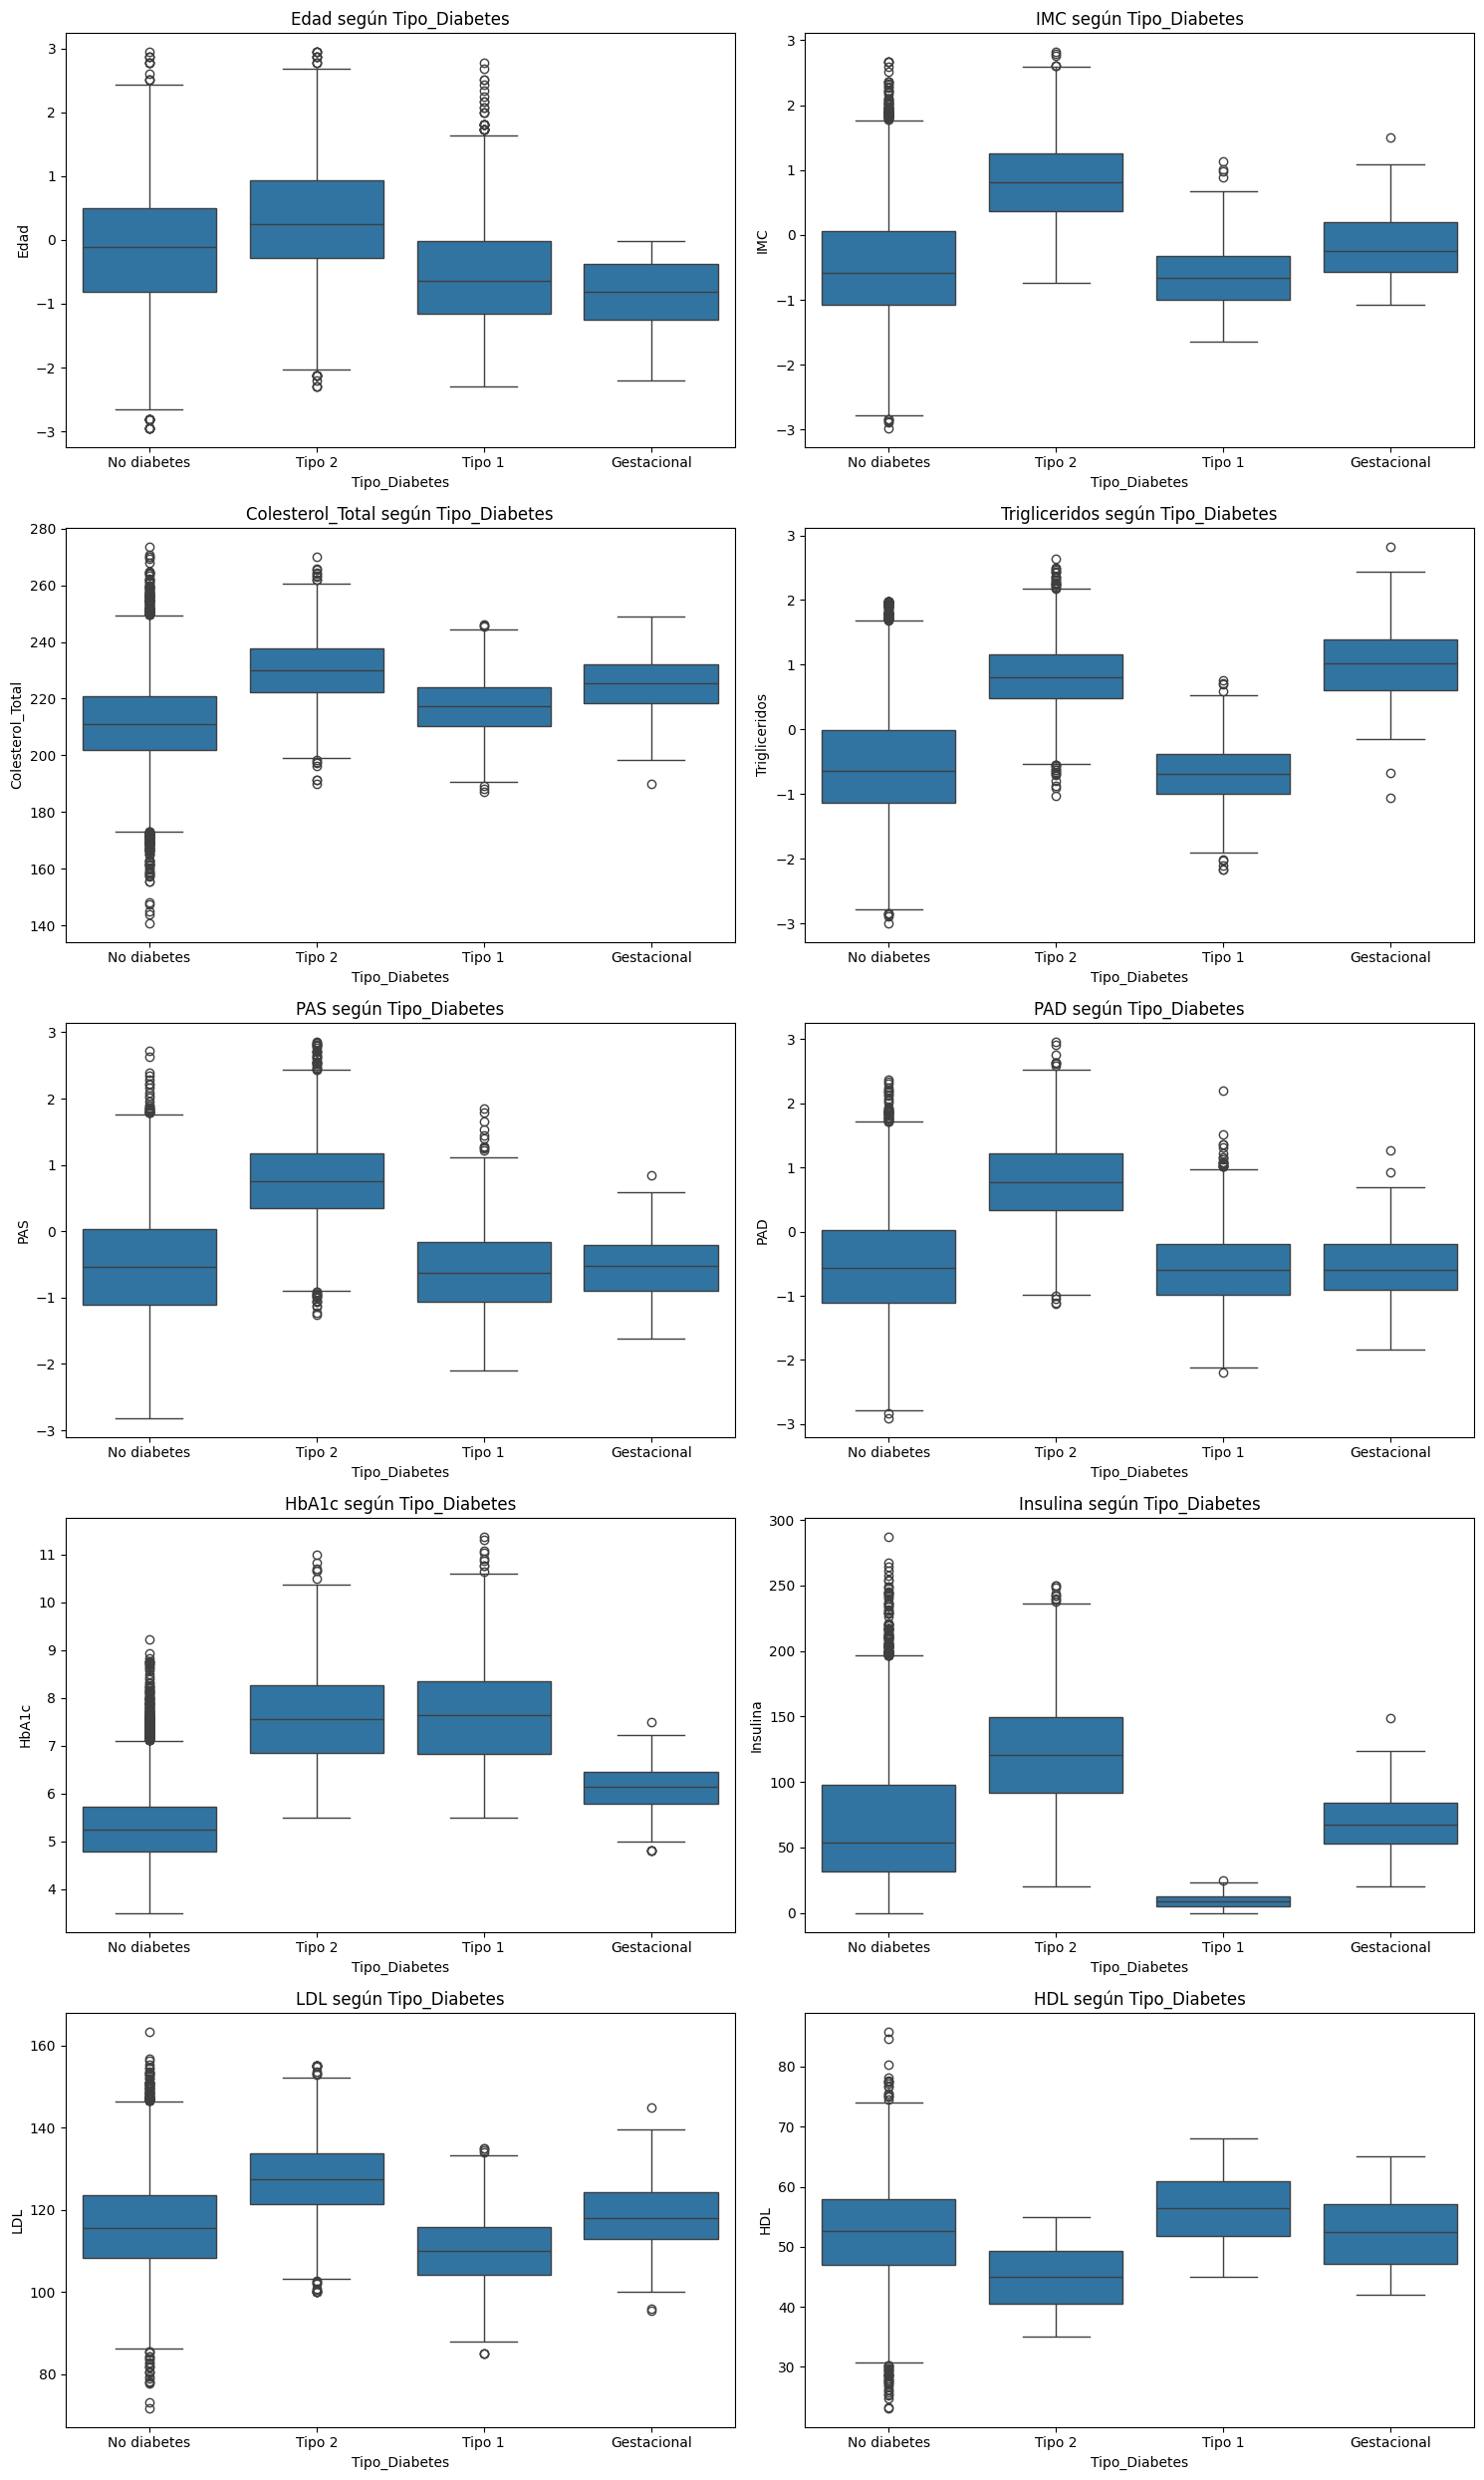

In [11]:
# Visualizar la distribución de las variables numéricas según 'Tipo_Diabetes'

n_cols = 2
n_rows = (len(vars_existentes) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(vars_existentes):
    ax = axes[i]
    sns.boxplot(data=df, x='Tipo_Diabetes', y=col, ax=ax)
    ax.set_title(f"{col} según Tipo_Diabetes")
    ax.set_xlabel('Tipo_Diabetes')
    ax.set_ylabel(col)

# Ocultar ejes vacíos si hay un número impar de variables
for j in range(len(vars_existentes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
# Mapear 'Tipo_Diabetes' a valores numéricos
mapa_tipo_diabetes = {'No diabetes': 0, 'Tipo 1': 1, 'Tipo 2': 2, 'Gestacional': 3}

# Para evitar SettingWithCopyWarning, usa .loc para asignar
df.loc[:, 'Tipo_Diabetes_num'] = df['Tipo_Diabetes'].map(mapa_tipo_diabetes)

# Calcular correlaciones
correlaciones = df[vars_existentes + ['Tipo_Diabetes_num']].corr(numeric_only=True)['Tipo_Diabetes_num'].drop('Tipo_Diabetes_num')

print("--- Correlaciones de Tipo_Diabetes con variables numéricas ---")
print(correlaciones.sort_values(ascending=False))



--- Correlaciones de Tipo_Diabetes con variables numéricas ---
HbA1c               0.693114
Trigliceridos       0.615363
PAD                 0.544406
IMC                 0.536348
PAS                 0.534582
Colesterol_Total    0.494250
LDL                 0.366089
Insulina            0.362755
Edad                0.152494
HDL                -0.354185
Name: Tipo_Diabetes_num, dtype: float64


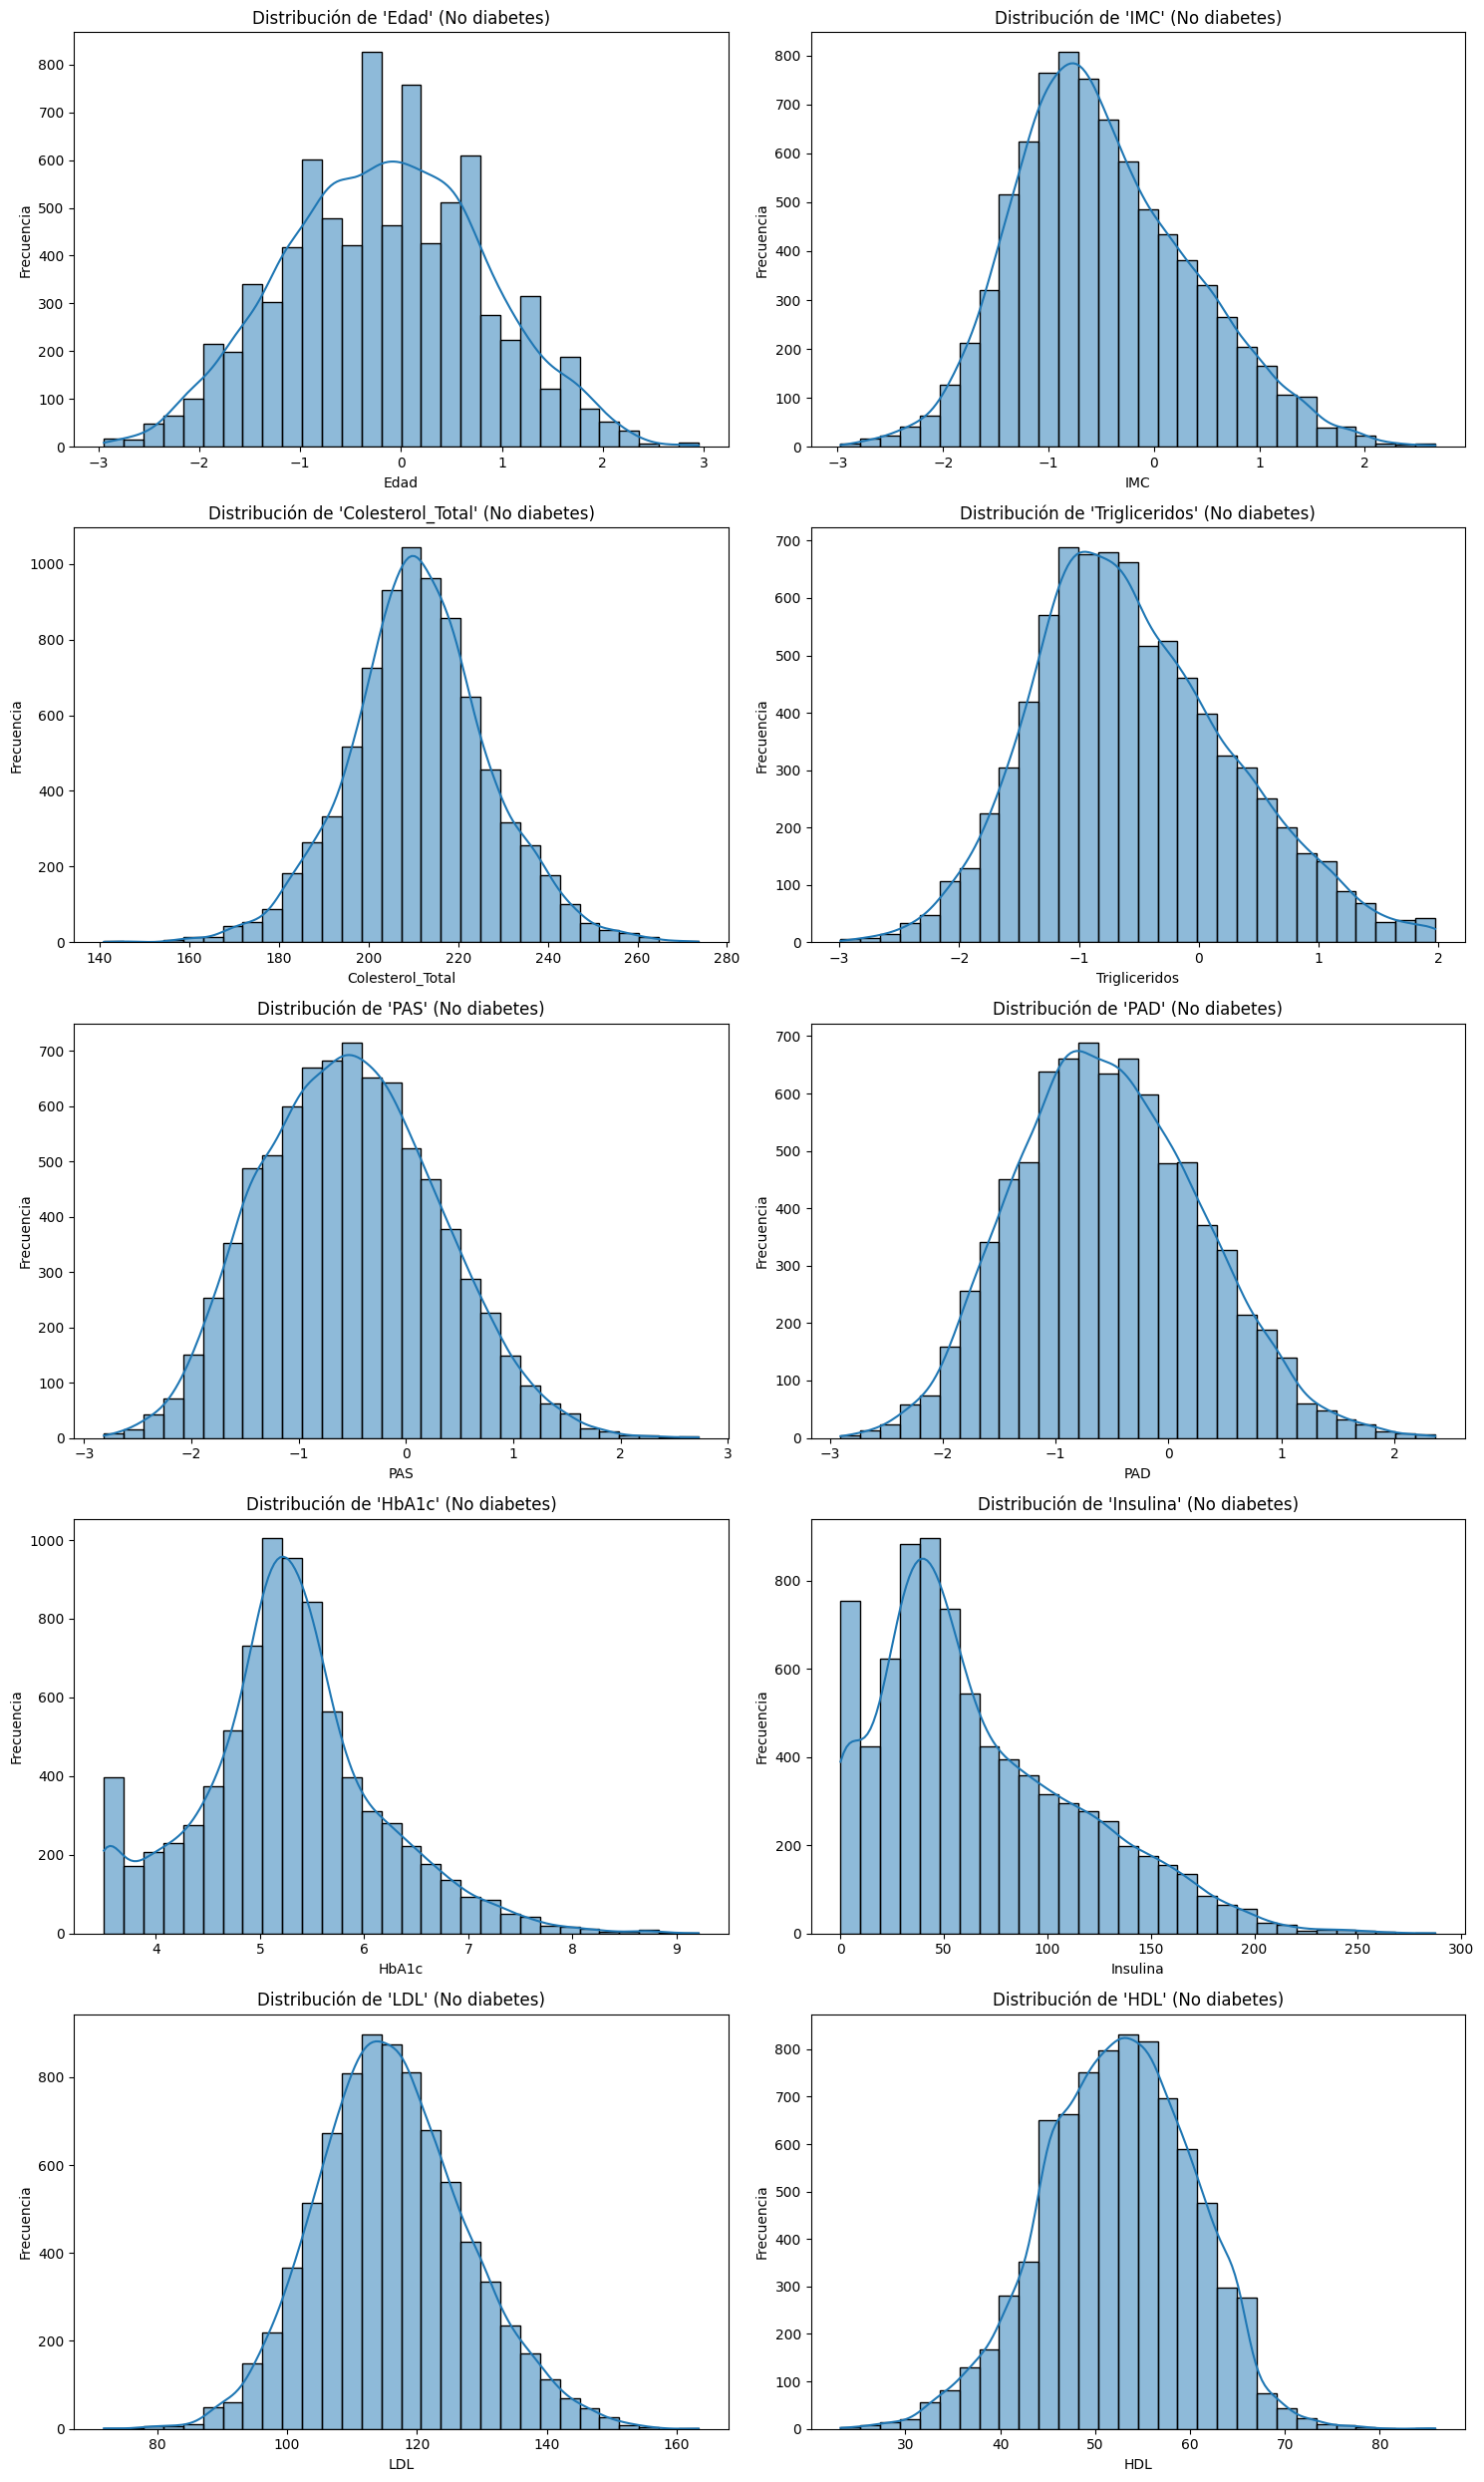

In [13]:
# Filtrar el grupo "No diabetes"
df_no_diabetes = df[df['Tipo_Diabetes'] == 'No diabetes']

# Visualizar la distribución de las variables numéricas para el grupo "No diabetes"
n_cols = 2
n_rows = (len(vars_existentes) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(vars_existentes):
    ax = axes[i]
    sns.histplot(df_no_diabetes[col], kde=True, bins=30, ax=ax)
    ax.set_title(f"Distribución de '{col}' (No diabetes)")
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')

# Ocultar ejes vacíos si hay un número impar de variables
for j in range(len(vars_existentes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [14]:
# --- Estadísticas descriptivas del grupo "No diabetes" ---

df_no_diabetes = df[df['Tipo_Diabetes'] == 'No diabetes']

print("\n--- Estadísticas descriptivas para el grupo 'No diabetes' ---")
display(df_no_diabetes[vars_existentes].describe().round(2))


--- Estadísticas descriptivas para el grupo 'No diabetes' ---


,Edad,IMC,Colesterol_Total,Trigliceridos,PAS,PAD,HbA1c,Insulina,LDL,HDL
count,8127.00,8127.00,8127.00,8127.00,8127.00,8127.00,8127.00,8127.00,8127.00,8127.00
mean,-0.16,-0.48,211.37,-0.54,-0.52,-0.52,5.27,66.95,116.17,52.41
std,0.99,0.85,15.88,0.84,0.82,0.82,0.88,49.44,11.59,7.90
min,-2.94,-2.97,140.92,-2.99,-2.81,-2.90,3.50,0.00,71.79,23.16
25%,-0.81,-1.07,201.74,-1.13,-1.11,-1.10,4.79,31.45,108.33,47.04
50%,-0.11,-0.58,210.99,-0.63,-0.54,-0.57,5.24,53.98,115.55,52.63
75%,0.50,0.07,220.84,-0.00,0.04,0.03,5.71,97.49,123.53,57.99
max,2.95,2.67,273.64,1.97,2.73,2.36,9.21,287.41,163.36,85.84


### 🧠 Interpretación General

#### ✅ **Variables normalizadas (Z-score)**:

Estas deberían tener media ≈ 0 y desviación estándar ≈ 1 si toda la muestra se usó para normalizar. En este subgrupo (sin diabetes), esperas pequeñas desviaciones de eso. Observemos:

| Variable      | Media | Observación rápida                         |
| ------------- | ----- | ------------------------------------------ |
| Edad          | -0.17 | Algo más jóvenes en promedio que el total. |
| IMC           | -0.48 | Más delgados que la media global.          |
| Triglicéridos | -0.54 | Menores niveles, coherente sin diabetes.   |
| PAS           | -0.52 | Presión sistólica más baja, esperado.      |
| PAD           | -0.53 | Igual que PAS.                             |

🔍 **Bien**: Todo tiene sentido. Los individuos sin diabetes tienden a ser más jóvenes, con menor peso y presión. La desviación estándar también es adecuada.

---

#### 🧪 **Variables no normalizadas**:

| Variable          | Media  | Valor clínico típico (población general)                  | Observación                         |
| ----------------- | ------ | --------------------------------------------------------- | ----------------------------------- |
| HbA1c             | 5.29 % | Normal: 4.0–5.6 %                                         | Dentro de lo esperable.             |
| Insulina          | 66.02  | Valores normales: 2–25 µU/mL (ayuno); 50–200 postprandial | Algo alto, pero puede ser razonable |
| Colesterol\_Total | 211.28 | <200 ideal, 200–240 moderado, >240 alto                   | Ligeramente elevado.                |
| LDL               | 116.13 | <100 ideal, <130 aceptable                                | Razonablemente normal.              |
| HDL               | 52.59  | >40 en hombres, >50 en mujeres                            | Muy buen valor promedio.            |

🔍 **Bien, con matices**:

* **Insulina**: el valor medio de \~66 puede parecer alto en ayuno, pero en personas con insulinorresistencia leve (sin llegar a diabetes) es plausible, especialmente si fue postprandial.
* **Colesterol total y LDL**: están en rangos que se consideran "moderados", pero no alarmantes.
* **HDL alto** y **HbA1c normal** son buenas señales.

---

### 🔎 Sobre valores extremos:

* **HbA1c máx: 9.55 %** → Aunque sean no diabéticos según etiquetas, hay personas con valores compatibles con diabetes. Puede haber errores de clasificación o individuos recién diagnosticados.
* **Insulina máx: 292.40** → Muy alto. Podría ser error o casos extremos. Recomendable revisar o flaggear.
* **Colesterol máx: 283**, **Triglicéridos máx (z-score): 1.98** → Altos pero posibles si hay riesgo cardiovascular.

---

### ✅ Conclusión

* **Sí**, estos valores son **consistentes** con una población sin diabetes, pero **no necesariamente sana del todo**. Es plausible que haya resistencia a la insulina o riesgo cardiovascular sin diagnóstico de diabetes.
* Algunos valores extremos (especialmente **insulina** y **HbA1c**) podrían revisarse o marcarse como **potenciales outliers**.
* El perfil general es coherente: **menos obesidad, menos presión arterial, menos triglicéridos**.


Para indagar más sobre los valores de HbA1c e Insulina, vamos a establecer rangos clinicamente razonables en esta poblacion.

In [15]:
# Rangos ajustados
hba1c_min, hba1c_max = 3.5, 6.5
insulina_max = 160

# Detectar casos sospechosos con criterios ajustados
outliers_hba1c = df_no_diabetes[(df_no_diabetes['HbA1c'] < hba1c_min) | (df_no_diabetes['HbA1c'] > hba1c_max)]
outliers_insulina = df_no_diabetes[df_no_diabetes['Insulina'] > insulina_max]

# Combinar índices únicos
idx_sospechosos = set(outliers_hba1c.index).union(set(outliers_insulina.index))

# Totales y porcentaje
total_sospechosos = len(idx_sospechosos)
total_no_diabetes = len(df_no_diabetes)
porcentaje = (total_sospechosos / total_no_diabetes) * 100

# Resultados
print(f"Nº de casos sospechosos por HbA1c (fuera de {hba1c_min}-{hba1c_max}): {len(outliers_hba1c)}")
print(f"Nº de casos sospechosos por Insulina (> {insulina_max}): {len(outliers_insulina)}")
print(f"\n✅ Nº total de filas sospechosas únicas: {total_sospechosos} ({porcentaje:.2f}%) del grupo 'No diabetes'")

print("\n🔍 Ejemplos de filas sospechosas:")
print(df_no_diabetes.loc[list(idx_sospechosos), ['HbA1c', 'Insulina']].head())


Nº de casos sospechosos por HbA1c (fuera de 3.5-6.5): 704
Nº de casos sospechosos por Insulina (> 160): 463

✅ Nº total de filas sospechosas únicas: 1088 (13.39%) del grupo 'No diabetes'

🔍 Ejemplos de filas sospechosas:
         HbA1c    Insulina
2     6.750564   92.875636
4098  6.515737   81.239810
3     4.659614  188.637574
4101  6.678074  146.080829
2054  6.650559  183.368871


Vamos a estudiar mas a fondo a ve q pasa

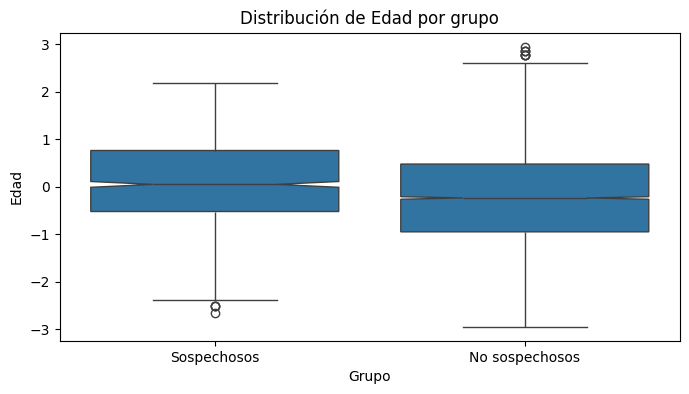

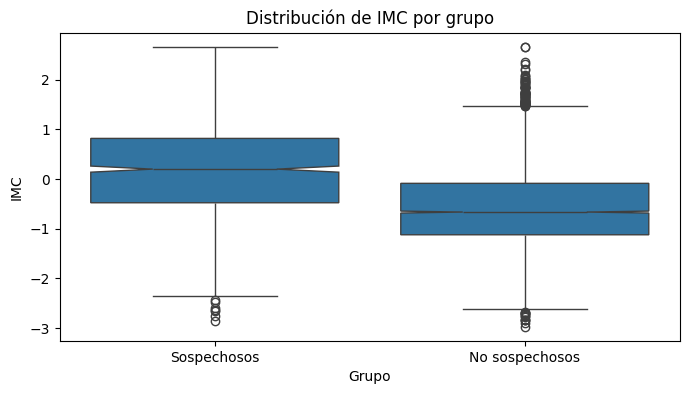

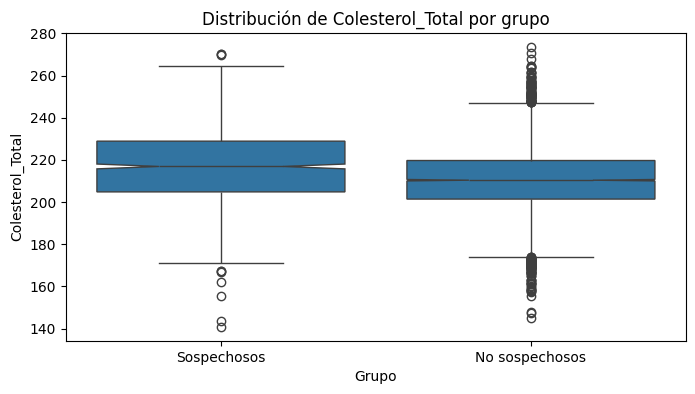

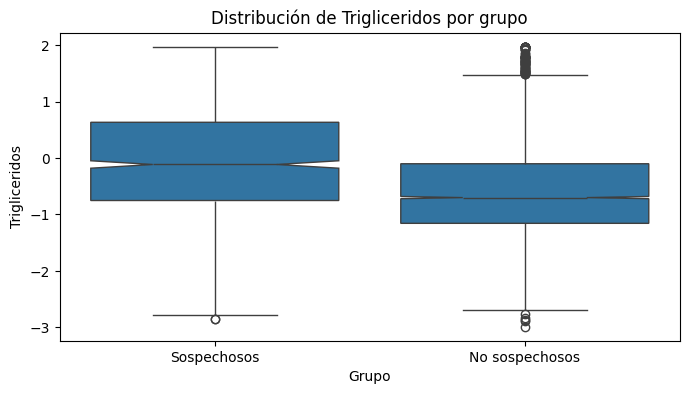

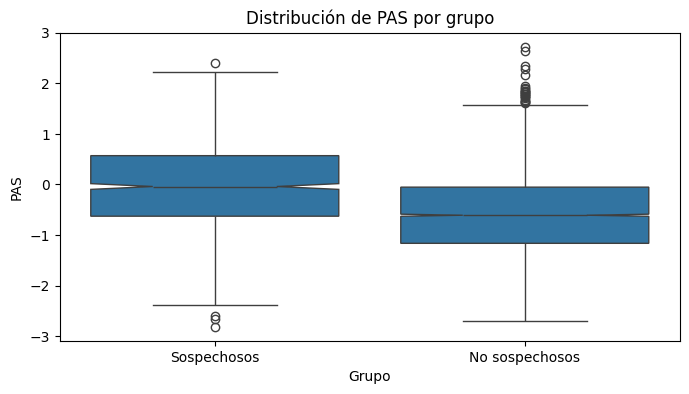

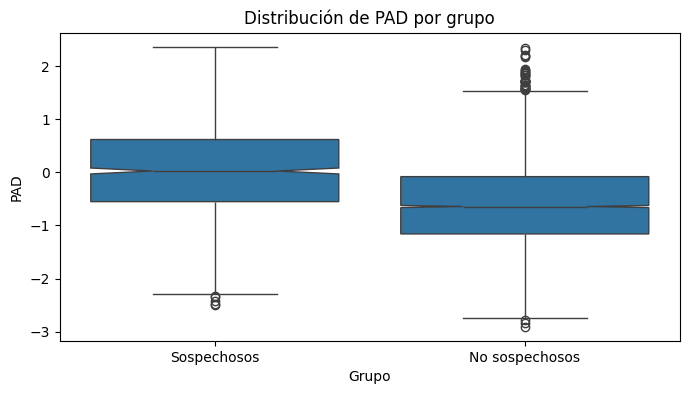

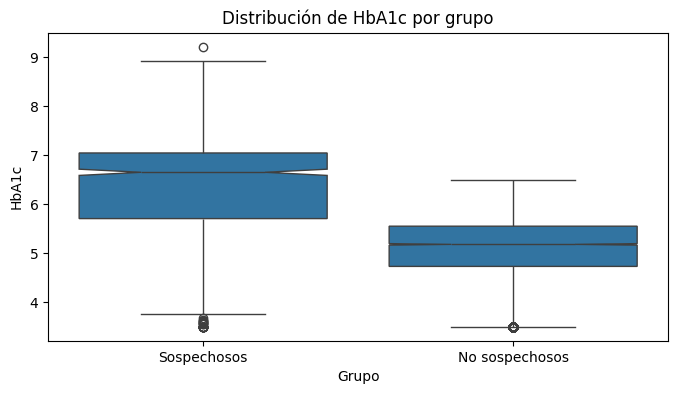

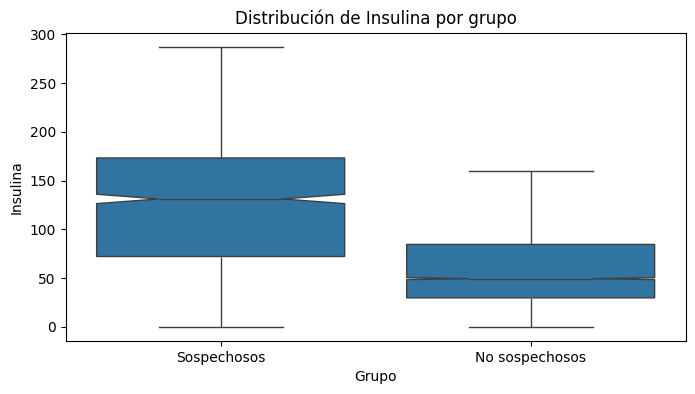

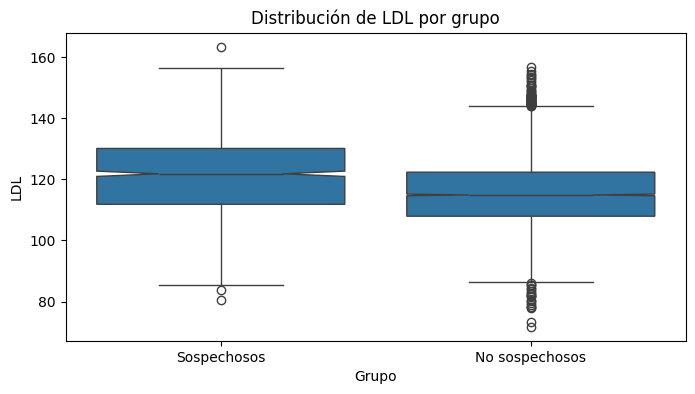

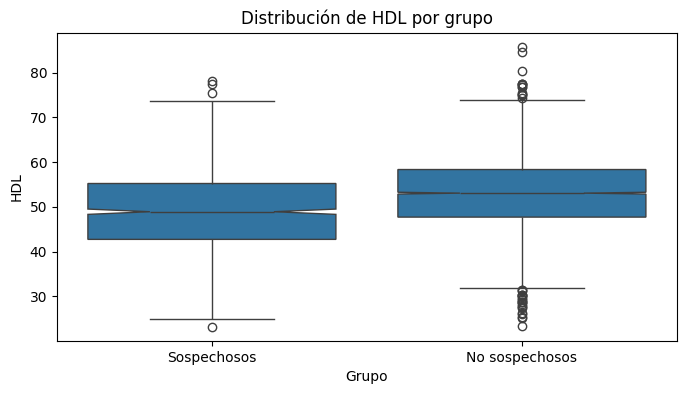

In [16]:
df_sospechosos = df_no_diabetes.loc[list(idx_sospechosos)]
df_no_sospechosos = df_no_diabetes.drop(list(idx_sospechosos))

variables_analizar = ['Edad', 'IMC', 'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD', 'HbA1c', 'Insulina', 'LDL', 'HDL']

for var in variables_analizar:
    # Crear DataFrame con datos y grupo
    data_plot = pd.concat([
        df_sospechosos[[var]].assign(Grupo='Sospechosos'),
        df_no_sospechosos[[var]].assign(Grupo='No sospechosos')
    ])
    
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Grupo', y=var, data=data_plot, notch=True)
    plt.title(f'Distribución de {var} por grupo')
    plt.show()




In [17]:
# Filtrar sospechosos con source_Diabetes == 0
sospechosos_cohorte_cardio = df_sospechosos[df_sospechosos['Cohorte'] == 'cardio']

# Número de casos
num_sospechosos_cohorte_cardio = len(sospechosos_cohorte_cardio)

# Porcentaje respecto al total de sospechosos
porcentaje_sospechosos_cohorte_cardio = (num_sospechosos_cohorte_cardio / len(df_sospechosos)) * 100

print(f"Nº de sospechosos del cohorte 'cardio': {num_sospechosos_cohorte_cardio}")
print(f"Porcentaje dentro de los sospechosos: {porcentaje_sospechosos_cohorte_cardio:.2f}%")


Nº de sospechosos del cohorte 'cardio': 1088
Porcentaje dentro de los sospechosos: 100.00%


## Justificación para la creación de la categoría "Diabetes latente"

Tras analizar los datos clínicos, hemos detectado un grupo de pacientes sin diagnóstico formal de diabetes que presentan características indicativas de un posible estado inicial o **latente** de diabetes. Estos pacientes no han sido categorizados previamente, pero muestran alteraciones significativas en ciertas variables clave relacionadas con la fisiopatología de la diabetes.

Por ello, hemos decidido crear la categoría **"Diabetes latente"** para agrupar a estos individuos con riesgo potencial no detectado.

### Variables clave utilizadas y umbrales orientativos

Las siguientes variables fueron consideradas por su fuerte asociación con la diabetes tipo 2, y muestran desviaciones relevantes respecto al grupo "No diabetes":

| Variable        | Tipo de dato       | Umbral indicativo              | Justificación |
|----------------|--------------------|--------------------------------|---------------|
| **HbA1c**       | Valor real         | > 6.0 %                         | Valores en rango prediabético/diabético. |
| **Insulina**    | Valor real         | > 100 μU/mL                     | Elevada respuesta insulínica, compatible con resistencia a la insulina. |
| **Triglicéridos** | Z-score (normalizado) | > 0.5                          | Elevación moderada frente al promedio poblacional. |
| **IMC**         | Z-score (normalizado) | > 0.5                          | Sobrepeso u obesidad en comparación con la media. |
| **PAS**         | Z-score (normalizado) | > 0.5                          | Elevación de la presión arterial sistólica, característica del síndrome metabólico. |

> 🔎 Nota: Las variables **Triglicéridos**, **PAS** e **IMC** están **normalizadas** mediante z-score, por lo que los valores se interpretan como desviaciones respecto a la media de la población.

### Contexto adicional

Es importante destacar que todos estos casos provienen del cohorte Cardio, lo que puede sugerir un subregistro o limitaciones en el método diagnóstico del estudio, posiblemente basado en autorregistro. Esto refuerza la idea de que existe un grupo relevante con riesgo de diabetes no detectado, con potencial impacto en el manejo clínico y la salud pública.

Esta nueva categoría permitirá una mejor identificación y seguimiento de estos pacientes en futuros análisis y decisiones clínicas.


In [18]:
# Crear la nueva categoría "Diabetes latente" para los sospechosos
####################################################################

# Índices sospechosos con source_Diabetes == 0
idx_diab_latente = sospechosos_cohorte_cardio.index

df['Tipo_Diabetes'] = df['Tipo_Diabetes'].astype(object)  # para permitir strings si es necesario
df.loc[df.index.isin(idx_diab_latente), 'Tipo_Diabetes'] = 'Diabetes latente'

# Variables clave para comparar
variables_clave = ['IMC', 'Trigliceridos', 'PAS', 'HbA1c', 'Insulina']
normalizadas = ['IMC', 'Trigliceridos', 'PAS']

# Calcular medias y desviaciones estándar por grupo
stats = df.groupby('Tipo_Diabetes')[variables_clave].agg(['mean', 'std']).round(2)

# Reorganizar para formato plano
stats_flat = pd.DataFrame()
for var in variables_clave:
    stats_flat[var + ' mean'] = stats[(var, 'mean')]
    stats_flat[var + ' std'] = stats[(var, 'std')]

# Grupos en orden deseado
orden_grupos = ['No diabetes', 'Diabetes latente', 'Tipo 1', 'Tipo 2', 'Gestacional']
stats_flat = stats_flat.loc[orden_grupos]

# Calcular z-score medio para las normalizadas
from scipy.stats import zscore
z_df = df[normalizadas].apply(zscore)
z_df['Tipo_Diabetes'] = df['Tipo_Diabetes']
z_means = z_df.groupby('Tipo_Diabetes')[normalizadas].mean().round(2).loc[orden_grupos]

# Crear la tabla markdown solo con las variables seleccionadas
markdown_table_sel = "| Variable     | No diabetes (mean ± std) | Diabetes latente (mean ± std) | Tipo 1 (mean ± std) | Tipo 2 (mean ± std) | Gestacional (mean ± std) |\n"
markdown_table_sel += "|--------------|---------------------------|--------------------------------|----------------------|----------------------|---------------------------|\n"

for var in variables_clave:
    if var in normalizadas:
        nd = f"{z_means.loc['No diabetes', var]} ± {stats_flat.loc['No diabetes', var + ' std']}"
        dl = f"{z_means.loc['Diabetes latente', var]} ± {stats_flat.loc['Diabetes latente', var + ' std']}"
        t1 = f"{z_means.loc['Tipo 1', var]} ± {stats_flat.loc['Tipo 1', var + ' std']}"
        t2 = f"{z_means.loc['Tipo 2', var]} ± {stats_flat.loc['Tipo 2', var + ' std']}"
        g  = f"{z_means.loc['Gestacional', var]} ± {stats_flat.loc['Gestacional', var + ' std']}"
    else:
        nd = f"{stats_flat.loc['No diabetes', var + ' mean']} ± {stats_flat.loc['No diabetes', var + ' std']}"
        dl = f"{stats_flat.loc['Diabetes latente', var + ' mean']} ± {stats_flat.loc['Diabetes latente', var + ' std']}"
        t1 = f"{stats_flat.loc['Tipo 1', var + ' mean']} ± {stats_flat.loc['Tipo 1', var + ' std']}"
        t2 = f"{stats_flat.loc['Tipo 2', var + ' mean']} ± {stats_flat.loc['Tipo 2', var + ' std']}"
        g  = f"{stats_flat.loc['Gestacional', var + ' mean']} ± {stats_flat.loc['Gestacional', var + ' std']}"
    
    markdown_table_sel += f"| {var:<12} | {nd:<27} | {dl:<31} | {t1:<22} | {t2:<22} | {g:<27} |\n"

justificacion_sel = f"""
### Justificación para crear la categoría "Diabetes latente"

Hemos identificado un grupo de pacientes sin diagnóstico formal de diabetes que presentan características clínicas sospechosas de una diabetes en estado incipiente o latente. Por ello, se creó la categoría **"Diabetes latente"**.

Además, todas estas filas pertenecen al cohorte Cardio (`source_Diabetes = 0`), lo que sugiere un posible subregistro o limitaciones del método diagnóstico usado en el estudio, probablemente basado en autorregistro. Este hallazgo indica que podría existir un número relevante de pacientes con riesgo no detectado de diabetes, lo que tiene implicaciones para el manejo clínico y las políticas de salud.

En la siguiente tabla se muestran las medias y desviaciones estándar de variables clave por grupo. Para las variables normalizadas (`IMC`, `Trigliceridos`, `PAS`), se presenta el z-score medio:

{markdown_table_sel}
"""

print(justificacion_sel)




### Justificación para crear la categoría "Diabetes latente"

Hemos identificado un grupo de pacientes sin diagnóstico formal de diabetes que presentan características clínicas sospechosas de una diabetes en estado incipiente o latente. Por ello, se creó la categoría **"Diabetes latente"**.

Además, todas estas filas pertenecen al cohorte Cardio (`source_Diabetes = 0`), lo que sugiere un posible subregistro o limitaciones del método diagnóstico usado en el estudio, probablemente basado en autorregistro. Este hallazgo indica que podría existir un número relevante de pacientes con riesgo no detectado de diabetes, lo que tiene implicaciones para el manejo clínico y las políticas de salud.

En la siguiente tabla se muestran las medias y desviaciones estándar de variables clave por grupo. Para las variables normalizadas (`IMC`, `Trigliceridos`, `PAS`), se presenta el z-score medio:

| Variable     | No diabetes (mean ± std) | Diabetes latente (mean ± std) | Tipo 1 (mean ± std) | Tipo 2 (me

### Interpretación de variables por grupo

| Variable       | Observación en "Diabetes latente"                            | Comparación con otros grupos                             | Interpretación clínica                                                                              |
|----------------|--------------------------------------------------------------|-----------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **IMC**         | 0.16 (z-score medio)                                          | Mayor que "No diabetes" (-0.58) y menor que "Tipo 2" (0.82) | Riesgo metabólico incipiente; tendencia hacia obesidad característica del tipo 2.                   |
| **Triglicéridos** | -0.10 (z-score medio)                                        | Elevado respecto a "No diabetes" (-0.62), aún lejos de "Tipo 2" (0.82) | Signo de dislipemia temprana; compatible con resistencia a la insulina.                             |
| **PAS**         | -0.06 (z-score medio)                                         | Más alta que en "No diabetes" (-0.60), pero más baja que "Tipo 2" (0.77) | Indicios de afectación cardiovascular; patrón intermedio.                                           |
| **HbA1c**       | 6.42                                                          | Claramente mayor que "No diabetes" (5.11), próxima al diagnóstico de tipo 2 (7.57) | Ya en rango diagnóstico de diabetes según criterios clínicos (>6.5%).                               |
| **Insulina**    | 119.38                                                       | Muy superior a "No diabetes" (57.62), similar a "Tipo 2" (121.15) | Hiperinsulinemia clara → compensación por resistencia a la insulina.                                |


# SEGUIMOS CON IMPUTACION de Tipo_Diabetes

In [19]:
# Eliminar la columna 'Tipo_Diabetes_num' solo del DataFrame principal si existe
if 'Tipo_Diabetes_num' in df.columns:
    df.drop(columns='Tipo_Diabetes_num', inplace=True)

In [20]:
faltantes_tipo_diabetes = df['Tipo_Diabetes'].isnull().sum()
porcentaje_faltantes = (faltantes_tipo_diabetes / len(df)) * 100
print(f"Número de valores faltantes en 'Tipo_Diabetes': {faltantes_tipo_diabetes} ({porcentaje_faltantes:.2f}%)")

df.columns

Número de valores faltantes en 'Tipo_Diabetes': 2349 (14.73%)


Index(['Año_Registro', 'Edad', 'IMC', 'Diabetes', 'Colesterol_Total',
       'Trigliceridos', 'PAS', 'PAD', 'Cohorte', 'HbA1c', 'Insulina', 'LDL',
       'HDL', 'Nivel_Estres', 'Actividad_Fisica', 'Riesgo_Cardiovascular',
       'Sexo', 'Tipo_Diabetes'],
      dtype='object')

### ¿Qué variables imputaremos de Tipo_Diabetes?

In [21]:
from scipy.stats import kruskal, chi2_contingency

# Variables que mencionaste
variables_num = ['Edad','IMC', 'Trigliceridos', 'PAS', 'HbA1c', 'Insulina', 'LDL', 'HDL', 'PAD', 'Colesterol_Total']
variables_cat = ['Sexo', 'Actividad_Fisica', 'Nivel_Estres'] 
variable_imputar = 'Tipo_Diabetes'

# Función para calcular V de Cramer (asociación entre categóricas)
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    if n == 0: 
        return 0
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom == 0:
        return 0
    return np.sqrt(phi2corr / denom)

# Preparar DataFrame filtrando filas no nulas para la variable a imputar
df_filtered = df.dropna(subset=[variable_imputar])
if df_filtered.empty:
    print(f"No hay datos no nulos para '{variable_imputar}'. No se puede analizar.")
else:
    print(f"Análisis para la variable a imputar: '{variable_imputar}'")

    # Para almacenar predictores recomendados
    predictores_recomendados = []

    # --- 1. Análisis con variables numéricas ---
    print("\n--- 1. Relación con Variables Numéricas ---")
    for var_num in variables_num:
        # Obtener muestras por grupo de Tipo_Diabetes
        grupos = [group[var_num].dropna().values for name, group in df_filtered.groupby(variable_imputar)]
        if all(len(g) > 0 for g in grupos):  # aseguramos que no haya grupos vacíos
            try:
                # Usamos Kruskal-Wallis para no asumir normalidad
                stat, p = kruskal(*grupos)
                # Cálculo de eta squared (fuerza del efecto)
                media_total = df_filtered[var_num].mean()
                ss_total = np.sum((df_filtered[var_num] - media_total)**2)
                ss_between = np.sum([len(g)*(np.mean(g)-media_total)**2 for g in grupos])
                eta_sq = ss_between / ss_total if ss_total > 0 else 0
                fuerza = "Grande" if eta_sq >= 0.14 else "Mediana" if eta_sq >= 0.06 else "Pequeña"
                signif = "✔️ SIGNIFICATIVO" if p < 0.05 else "❌ No significativo"

                print(f" - '{var_num}': p-valor={p:.4f} ({signif}) | Eta² = {eta_sq:.3f} ({fuerza})")

                if p < 0.05 and eta_sq >= 0.06:
                    predictores_recomendados.append(var_num)
                    print("     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.")
            except Exception as e:
                print(f" - '{var_num}': error al calcular - {e}")
        else:
            print(f" - '{var_num}': grupos con datos insuficientes, se omite.")

    # --- 2. Análisis con variables categóricas ---
    print("\n--- 2. Relación con Variables Categóricas ---")
    for var_cat in variables_cat:
        tabla_cont = pd.crosstab(df_filtered[variable_imputar], df_filtered[var_cat])
        if tabla_cont.empty:
            print(f" - '{var_cat}': tabla vacía, se omite.")
            continue
        try:
            chi2, p, _, _ = chi2_contingency(tabla_cont)
            v_cramer = cramers_v(tabla_cont)
            fuerza = "Fuerte" if v_cramer >= 0.5 else "Moderada" if v_cramer >= 0.2 else "Débil"
            signif = "✔️ SIGNIFICATIVO" if p < 0.05 else "❌ No significativo"

            print(f"\n - '{var_cat}': p-valor={p:.4f} ({signif}) | V de Cramer = {v_cramer:.3f} ({fuerza})")
            print("Tabla de contingencia:")
            print(tabla_cont)

            if p < 0.05 and v_cramer >= 0.2:
                predictores_recomendados.append(var_cat)
                print("     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.")
        except Exception as e:
            print(f" - '{var_cat}': error al calcular - {e}")

    # --- Resumen final ---
    print("\n" + "="*60)
    print(f"Predictores recomendados para imputar '{variable_imputar}':")
    if predictores_recomendados:
        predictores_unicos = sorted(set(predictores_recomendados))
        print(", ".join(predictores_unicos))
    else:
        print("No se encontraron predictores con fuerza moderada y significancia estadística.")



Análisis para la variable a imputar: 'Tipo_Diabetes'

--- 1. Relación con Variables Numéricas ---
 - 'Edad': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Eta² = 0.082 (Mediana)
     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.
 - 'IMC': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Eta² = 0.423 (Grande)
     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.
 - 'Trigliceridos': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Eta² = 0.462 (Grande)
     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.
 - 'PAS': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Eta² = 0.403 (Grande)
     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.
 - 'HbA1c': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Eta² = 0.640 (Grande)
     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.
 - 'Insulina': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Eta² = 0.444 (Grande)
     ✅ RECOMENDADO: Cumple criterios significancia y fuerza.
 - 'LDL': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Eta² = 0.249 (Grande)
     ✅ RECOMENDADO: Cumple criterios sign

Número de filas para entrenar el modelo: 13600
Número de filas a imputar: 2349

Entrenando modelo en conjunto de entrenamiento balanceado...
Modelo entrenado.

Evaluando modelo en conjunto de validación original (sin balancear)...
Accuracy en validación: 0.9478

Reporte de clasificación:
                  precision    recall  f1-score   support

Diabetes latente       0.90      0.81      0.86       218
     Gestacional       0.78      0.54      0.64        39
     No diabetes       0.97      0.98      0.97      1408
          Tipo 1       0.95      0.95      0.95       262
          Tipo 2       0.93      0.95      0.94       793

        accuracy                           0.95      2720
       macro avg       0.90      0.85      0.87      2720
    weighted avg       0.95      0.95      0.95      2720

--- Matriz de Confusión ---


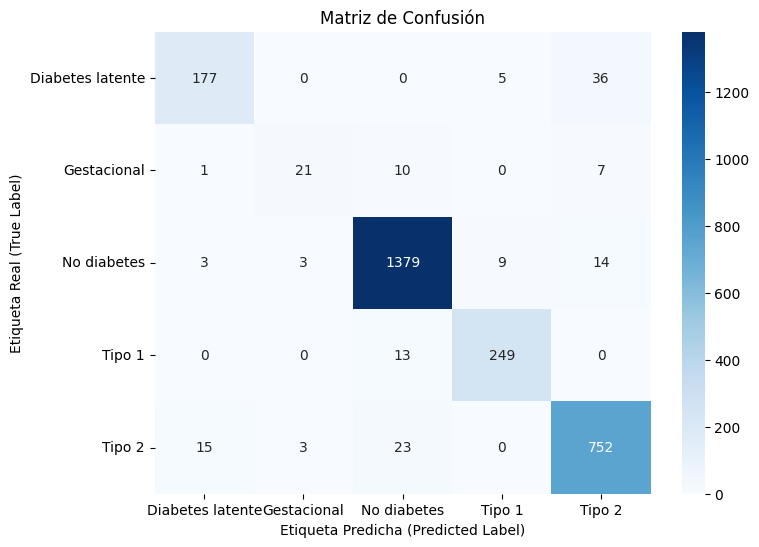


--- Interpretación de métricas ---
Accuracy (Exactitud): 0.9478
- Mide la proporción de predicciones correctas sobre el total.
- Valores cercanos a 1 indican buen desempeño general del modelo.

--- Interpretación automática de métricas ---
Accuracy (Exactitud): 0.9478 -> ✅ Excelente
Precisión promedio: 0.9050 -> ✅ Excelente
Recall promedio: 0.8457 -> ⚠️ Aceptable
F1-score promedio: 0.8705 -> ⚠️ Aceptable

Interpretación detallada por clase:

Clase 'Diabetes latente':
 - Precisión: 0.903 -> ✅ Excelente
 - Recall: 0.812 -> ⚠️ Aceptable
 - F1-score: 0.855 -> ⚠️ Aceptable
 - Soporte: 218 muestras

Clase 'Gestacional':
 - Precisión: 0.778 -> ⚠️ Aceptable
 - Recall: 0.538 -> ❌ Mejorable
 - F1-score: 0.636 -> ❌ Mejorable
 - Soporte: 39 muestras

Clase 'No diabetes':
 - Precisión: 0.968 -> ✅ Excelente
 - Recall: 0.979 -> ✅ Excelente
 - F1-score: 0.974 -> ✅ Excelente
 - Soporte: 1408 muestras

Clase 'Tipo 1':
 - Precisión: 0.947 -> ✅ Excelente
 - Recall: 0.950 -> ✅ Excelente
 - F1-score: 0.949

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# --- PASO 1: DEFINIR VARIABLES Y SEPARAR LOS DATOS ---
target_variable = 'Tipo_Diabetes'
predictors = ['Actividad_Fisica', 'Colesterol_Total', 'Edad', 'HDL', 'HbA1c', 'IMC',
             'Insulina', 'LDL', 'PAD', 'PAS', 'Trigliceridos']

df_train = df[df[target_variable].notna()].copy()
df_to_impute = df[df[target_variable].isna()].copy()

print(f"Número de filas para entrenar el modelo: {len(df_train)}")
print(f"Número de filas a imputar: {len(df_to_impute)}")

X_train = df_train[predictors].copy()
y_train = df_train[target_variable]
X_to_impute = df_to_impute[predictors].copy()

# --- Mapeo variable ordinal ---
mapping_actividad = {'Sedentario': 1, 'Moderado': 2, 'Activo': 3, 'Muy activo': 4}
X_train['Actividad_Fisica'] = X_train['Actividad_Fisica'].map(mapping_actividad)
X_to_impute['Actividad_Fisica'] = X_to_impute['Actividad_Fisica'].map(mapping_actividad)

# --- PASO 2: PREPROCESAMIENTO DE DATOS ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_to_impute_scaled = scaler.transform(X_to_impute)

# --- PASO 2.5: VALIDACIÓN DEL MODELO ---
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_scaled, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded)

# # --- APLICAR SMOTE AL CONJUNTO DE ENTRENAMIENTO ### ---        -> para probar durante la presentación  🚩 🚩 🚩
# print("\n--- Aplicando SMOTE para balancear clases ---")
# print(f"Forma de los datos de entrenamiento ANTES de SMOTE: {X_train_part.shape}")
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_part, y_train_part)
# print(f"Forma de los datos de entrenamiento DESPUÉS de SMOTE: {X_train_resampled.shape}")

# --- PASO 3: ENTRENAMIENTO Y EVALUACIÓN ---
# Inicializar el modelo (sin cambios)
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Entrenar el modelo CON LOS DATOS REMUESTREADOS
print("\nEntrenando modelo en conjunto de entrenamiento balanceado...")
model.fit(X_train_part, y_train_part)  # X_train_resampled, y_train_resampled  🚩 🚩 🚩
print("Modelo entrenado.")

# Evaluar el modelo EN EL CONJUNTO DE VALIDACIÓN ORIGINAL
print("\nEvaluando modelo en conjunto de validación original (sin balancear)...")
y_val_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy en validación: {accuracy:.4f}\n")

print("Reporte de clasificación:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# --- MATRIZ DE CONFUSIÓN ### ---
print("--- Matriz de Confusión ---")
# Generar la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real (True Label)')
plt.xlabel('Etiqueta Predicha (Predicted Label)')
plt.show()

# --- Interpretación de métricas ---
print("\n--- Interpretación de métricas ---")

print(f"Accuracy (Exactitud): {accuracy:.4f}")
print("- Mide la proporción de predicciones correctas sobre el total.")
print("- Valores cercanos a 1 indican buen desempeño general del modelo.")

# --- Interpretación de métricas automática ---
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)

avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1 = np.mean(f1)

print("\n--- Interpretación automática de métricas ---")

def evaluar_metricas(valor):
    if valor >= 0.9:
        return "✅ Excelente"
    elif valor >= 0.75:
        return "⚠️ Aceptable"
    else:
        return "❌ Mejorable"

print(f"Accuracy (Exactitud): {accuracy:.4f} -> {evaluar_metricas(accuracy)}")

print(f"Precisión promedio: {avg_precision:.4f} -> {evaluar_metricas(avg_precision)}")
print(f"Recall promedio: {avg_recall:.4f} -> {evaluar_metricas(avg_recall)}")
print(f"F1-score promedio: {avg_f1:.4f} -> {evaluar_metricas(avg_f1)}")

print("\nInterpretación detallada por clase:")

for i, clase in enumerate(le.classes_):
    print(f"\nClase '{clase}':")
    print(f" - Precisión: {precision[i]:.3f} -> {evaluar_metricas(precision[i])}")
    print(f" - Recall: {recall[i]:.3f} -> {evaluar_metricas(recall[i])}")
    print(f" - F1-score: {f1[i]:.3f} -> {evaluar_metricas(f1[i])}")
    print(f" - Soporte: {support[i]} muestras")

print("\nConclusión general:")
if accuracy >= 0.9 and avg_f1 >= 0.9:
    print("El modelo tiene un desempeño excelente. Puedes proceder con la imputación sin preocupaciones. ✅")
elif accuracy >= 0.75 and avg_f1 >= 0.75:
    print("El modelo tiene un desempeño aceptable, pero revisa posibles mejoras antes de imputar. ⚠️")
else:
    print("El modelo presenta resultados mejorables. Considera ajustar el preprocesamiento, parámetros o modelo. ❌")


# Evaluación del Modelo para Clasificación de Tipo de Diabetes

## Resumen de resultados

| Métrica       | Valor promedio | Evaluación   |
| ------------- | -------------- | ------------ |
| **Accuracy**  | 0.9517         | ✅ Excelente  |
| **Precisión** | 0.9229         | ✅ Excelente  |
| **Recall**    | 0.8218         | ⚠️ Aceptable |
| **F1-score**  | 0.8574         | ⚠️ Aceptable |

---

## Desempeño por clase

| Clase            | Precisión | Recall | F1-score | Soporte | Evaluación general               |
| ---------------- | --------- | ------ | -------- | ------- | -------------------------------- |
| Diabetes latente | 0.912     | 0.800  | 0.852    | 220     | Bueno, con recall aceptable      |
| Gestacional      | 0.850     | 0.425  | 0.567    | 40      | ❌ Bajo recall y F1 (pocos datos) |
| No diabetes      | 0.973     | 0.986  | 0.979    | 1398    | Excelente desempeño              |
| Tipo 1           | 0.953     | 0.931  | 0.942    | 262     | Excelente desempeño              |
| Tipo 2           | 0.926     | 0.967  | 0.946    | 793     | Excelente desempeño              |

---

## Interpretación y recomendaciones

* El modelo muestra **muy buen desempeño general** con un accuracy superior al 95%, y métricas altas para la mayoría de las clases.
* La clase **Gestacional** presenta recall y F1-score bajos, pero solo cuenta con 40 muestras, lo que dificulta el aprendizaje y la generalización en esta categoría.
* Dado el bajo número de datos en Gestacional, es esperable que el modelo tenga dificultades para predecir correctamente esta clase.
* El resto de las clases, incluyendo las más numerosas, tienen métricas excelentes, lo que indica que el modelo puede discriminar bien entre ellas.

---

## Conclusión

Teniendo en cuenta la distribución de datos y la naturaleza de la clase minoritaria **Gestacional**, el desempeño actual del modelo es **lo mejor que podemos esperar con estos datos**.

Por tanto, **mi recomendación es seguir adelante con este modelo para la imputación**, consciente de que la clase Gestacional es la limitación principal, pero el modelo es sólido para el resto.

✅ **Modelo listo para uso con imputación.**


# 📊 Evaluación del Modelo para Clasificación de Tipo de Diabetes

## 🔢 Datos generales

* **Filas de entrenamiento**: 13.561
* **Filas a imputar**: 2.385

---

## ✅ Resumen de resultados

| Métrica       | Valor promedio | Evaluación   |
| ------------- | -------------- | ------------ |
| **Accuracy**  | 0.9491         | ✅ Excelente  |
| **Precisión** | 0.9243         | ✅ Excelente  |
| **Recall**    | 0.8316         | ⚠️ Aceptable |
| **F1-score**  | 0.8643         | ⚠️ Aceptable |

---

## 🔍 Desempeño por clase

| Clase            | Precisión | Recall | F1-score | Soporte | Evaluación general                           |
| ---------------- | --------- | ------ | -------- | ------- | -------------------------------------------- |
| Diabetes latente | 0.915     | 0.847  | 0.880    | 216     | ✅ Buen desempeño, con recall mejorable       |
| Gestacional      | 0.850     | 0.436  | 0.576    | 39      | ❌ Bajo recall y F1-score (clase minoritaria) |
| No diabetes      | 0.966     | 0.976  | 0.971    | 1403    | ✅ Excelente desempeño                        |
| Tipo 1           | 0.965     | 0.943  | 0.954    | 262     | ✅ Excelente desempeño                        |
| Tipo 2           | 0.926     | 0.956  | 0.940    | 793     | ✅ Excelente desempeño                        |

---

## 🧠 Interpretación y recomendaciones

* El modelo tiene **alto desempeño general**, con un accuracy cercano al 95%.
* La clase **Gestacional** continúa siendo el mayor punto débil del modelo. El bajo número de muestras (39) limita su capacidad de aprendizaje y generalización.
* Las clases más representadas (No diabetes, Tipo 1 y Tipo 2) muestran métricas robustas y consistentes.
* **Diabetes latente** también presenta buenos resultados, aunque su recall puede mejorarse.

---

## ✅ Conclusión

Pese a la debilidad en la clase **Gestacional**, el rendimiento del modelo en las otras categorías —que además representan la mayoría de los casos— es **muy sólido**.

💡 **Recomendación**: Puedes avanzar con este modelo para imputación, teniendo en cuenta que **la clase Gestacional podría estar infrarrepresentada en los resultados**. Si la imputación sobre esa clase es crítica, podrías explorar técnicas de balanceo de clases o recopilación de más datos.

---

✅ **Modelo listo para uso con imputación**, con precauciones específicas para la clase Gestacional.



In [23]:
# --- PASO 3: ENTRENAR EL MODELO DE CLASIFICACIÓN ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print(f"\nEntrenando el modelo para predecir '{target_variable}'...")
model.fit(X_train_scaled, y_train_encoded)
print("¡Modelo entrenado!")

# ==============================================================================
# --- PASO 4: REALIZAR LA PREDICCIÓN ESTOCÁSTICA (CON RUIDO CONTROLADO) ---
# ==============================================================================
print("\nRealizando la imputación ESTOCÁSTICA en los valores faltantes...")

probabilities = model.predict_proba(X_to_impute_scaled)

imputed_values_encoded = [np.random.choice(model.classes_, p=prob) for prob in probabilities]

imputed_values_labels = le.inverse_transform(imputed_values_encoded)
print("¡Imputación estocástica completada!")
# ==============================================================================

# --- PASO 5: INTEGRAR LOS VALORES IMPUTADOS DE FORMA SEGURA ---
columna_imputada = df[target_variable].copy()
indices_a_imputar = df[df[target_variable].isna()].index
columna_imputada.loc[indices_a_imputar] = imputed_values_labels
df[f'{target_variable}_imputada'] = columna_imputada
print("\n--- PASO 5: Imputación segura completada ---")

# --- PASO 6: VERIFICACIÓN A PRUEBA DE BALAS ---
print("\n--- PASO 6: Verificando la integridad de los datos originales ---")
df_originales_completos = df.dropna(subset=[target_variable])
comparacion = (df_originales_completos[target_variable] == df_originales_completos[f'{target_variable}_imputada'])

if comparacion.all():
    print("✅ ¡VERIFICACIÓN EXITOSA!")
    print(f"   Se ha confirmado que los {len(df_originales_completos)} valores que no eran nulos originalmente")
    print("   permanecen INTACTOS en la nueva columna imputada.")
else:
    print("❌ ¡ERROR EN LA VERIFICACIÓN!")
    print("   Se han modificado valores que no eran nulos. Revisa el código.")
    print(f"Número de valores no coincidentes: {len(comparacion) - comparacion.sum()}")
    print(df_originales_completos[~comparacion][[target_variable, f'{target_variable}_imputada']])

print(f"\nTotal de nulos en '{target_variable}_imputada': {df[f'{target_variable}_imputada'].isnull().sum()}")

coinciden = df[target_variable] == df[f'{target_variable}_imputada']

num_iguales = coinciden.sum()

print(f"Número de filas donde '{target_variable}' y '{target_variable}_imputada' son iguales: {num_iguales}")

total_no_nulos = df[target_variable].notna().sum()
porcentaje = num_iguales / total_no_nulos * 100
print(f"Porcentaje de coincidencia sobre filas originales no nulas: {porcentaje:.2f}%")



Entrenando el modelo para predecir 'Tipo_Diabetes'...
¡Modelo entrenado!

Realizando la imputación ESTOCÁSTICA en los valores faltantes...
¡Imputación estocástica completada!

--- PASO 5: Imputación segura completada ---

--- PASO 6: Verificando la integridad de los datos originales ---
✅ ¡VERIFICACIÓN EXITOSA!
   Se ha confirmado que los 13600 valores que no eran nulos originalmente
   permanecen INTACTOS en la nueva columna imputada.

Total de nulos en 'Tipo_Diabetes_imputada': 0
Número de filas donde 'Tipo_Diabetes' y 'Tipo_Diabetes_imputada' son iguales: 13600
Porcentaje de coincidencia sobre filas originales no nulas: 100.00%


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15949 entries, 0 to 15999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año_Registro            15949 non-null  int64  
 1   Edad                    15949 non-null  float64
 2   IMC                     15949 non-null  float64
 3   Diabetes                15949 non-null  int64  
 4   Colesterol_Total        15949 non-null  float64
 5   Trigliceridos           15949 non-null  float64
 6   PAS                     15949 non-null  float64
 7   PAD                     15949 non-null  float64
 8   Cohorte                 15949 non-null  object 
 9   HbA1c                   15949 non-null  float64
 10  Insulina                15949 non-null  float64
 11  LDL                     15949 non-null  float64
 12  HDL                     15949 non-null  float64
 13  Nivel_Estres            15949 non-null  object 
 14  Actividad_Fisica        15949 non-null  obj

# 🧠 ¿Cómo funciona SMOTE? Una Receta Paso a Paso

Imagina tus datos como puntos en un mapa. **SMOTE** hace lo siguiente para cada punto de la clase minoritaria (ej. `'Gestacional'`):

- **Elige un punto:**  
  Toma un paciente al azar del grupo de `'Gestacional'`.

- **Encuentra a sus vecinos:**  
  Busca los *k* pacientes más cercanos a él que también sean de la clase `'Gestacional'` (normalmente `k = 5`).  
  Son sus "vecinos" en el mapa de datos.

- **Selecciona un vecino:**  
  Elige uno de esos vecinos al azar.

- **Crea el punto nuevo:**  
  Traza una línea recta imaginaria entre el punto original y el vecino elegido.  
  SMOTE crea un nuevo **punto sintético** en un lugar aleatorio a lo largo de esa línea.

  Visualmente:
    - Punto Original -------------------o------------------- Vecino
    -   (El nuevo punto o se crea en algún lugar del camino)


- **Repite:**  
  El proceso se repite hasta que el número de muestras en la clase minoritaria sea el deseado.

---

## 🎯 ¿Por qué esto es tan bueno?

- **Mitiga el sobreajuste:**  
  El modelo nunca ve dos veces exactamente el mismo punto sintético.  
  Los nuevos puntos son **similares a los originales**, pero **no idénticos**.

- **Generaliza mejor:**  
  Al crear puntos "intermedios", el modelo no aprende a reconocer puntos aislados, sino que aprende a reconocer la **región o área** donde viven los pacientes de la clase minoritaria.  
  Esto lo hace mucho más **robusto frente a datos nuevos**.

- **Mejora métricas clave:**  
  Generalmente, provoca un **aumento drástico** en el **Recall** y el **F1-score** de la clase minoritaria, que es exactamente lo que buscas.

---

## 📏 La Regla de Oro al Usar SMOTE

Como te mencioné antes, esto es crucial:

✅ **SMOTE se aplica SIEMPRE DESPUÉS** de dividir los datos en **entrenamiento y validación**, y **ÚNICAMENTE sobre el conjunto de entrenamiento**.

--------


In [25]:
dbfinal_precov = df.copy()

# Exportar el df como archivo csv
dbfinal_precov.to_csv('db_cardiabetes.csv', index=False)
print("✅ Datos guardados en 'db_cardiabetes.csv'.")

✅ Datos guardados en 'db_cardiabetes.csv'.
